## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1: Camera calibration via chessboard images. 

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images

#images=os.listdir('camera_cal')
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        ''' Commenting this section to stop slowing code execution during dev work. 
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()'''
print('Object and Image points collected')

Object and Image points collected


#### Using the object points and image points, undistort a calibration image and check the output

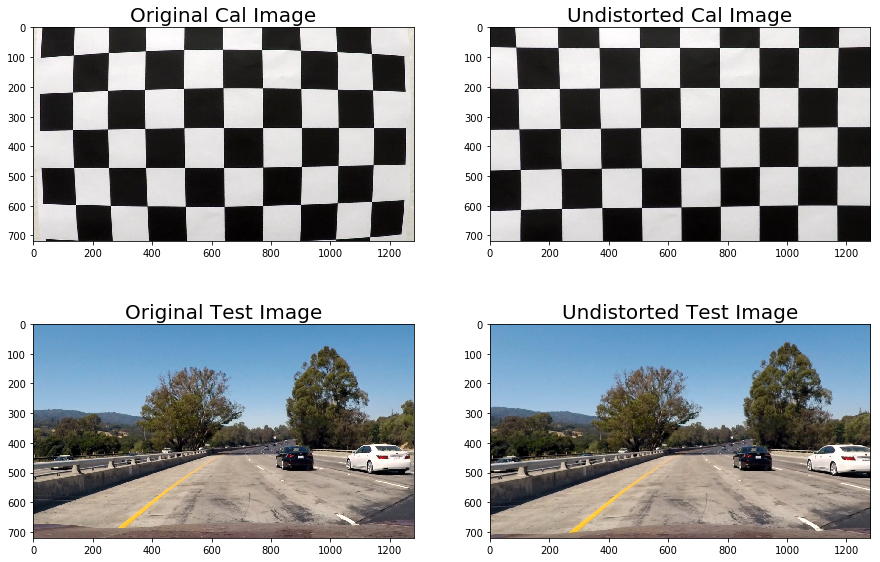

In [3]:
## Create camera calibration matrices using object and image points. 

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
## Verify capability of test matrix. 
calimg=mpimg.imread(images[0])
cal_undst = cv2.undistort(calimg, mtx, dist, None, mtx)
testimg=mpimg.imread('./test_images/test1.jpg')
test_undst = cv2.undistort(testimg, mtx, dist, None, mtx)


## Switch to inline plotting

%matplotlib inline

f1, ax1 = plt.subplots(2, 2,figsize=(15,10));
ax1[0,0].imshow(calimg)
ax1[0,0].set_title('Original Cal Image',fontsize=20);
ax1[0,1].imshow(cal_undst)
ax1[0,1].set_title('Undistorted Cal Image',fontsize=20);
ax1[1,0].imshow(testimg)
ax1[1,0].set_title('Original Test Image',fontsize=20);
ax1[1,1].imshow(test_undst)
ax1[1,1].set_title('Undistorted Test Image',fontsize=20);


### Step 2. Colorspace and gradient exploration.

For this I intend to use all of the test images but first I will define each function individually and test on a single test image to verify function. 

In previous projects and lessons, the YUV and LAB colorspaces showed strenghts in identifying features. I am going to create helper functions for that as well. The HLS mentioned in this lesson is included as well. 

I am going to build smaller individual functions to observe their effects and then use this library of small functions to construct the pipeline with each step being easily observable if required. 

In [4]:
def yuv_chn(img,channelIndex):
    tgt_channel = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, channelIndex]
    return tgt_channel

def lab_chn(img,channelIndex):
    tgt_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:, :, channelIndex]
    return tgt_channel

def hsv_chn(img,channelIndex):
    tgt_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:, :, channelIndex]
    return tgt_channel

def hls_chn(img,channelIndex):
    tgt_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, channelIndex]
    return tgt_channel

def rgb_chn(img,channelIndex):
    tgt_channel = img[:, :, channelIndex]
    return tgt_channel

## Gradient function development 

In order to find more generalized edges in the image, sobel gradients in the x and y direction will be used. 
As done in the lesson, I will test this on S channel image from HLS colorspace. 

In [5]:
## define the sobels in x and y
def sobelx(sngl_chn_img):
    abs_sobel=np.abs(cv2.Sobel(sngl_chn_img, cv2.CV_64F, 1, 0))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    return scaled_sobel

def sobely(sngl_chn_img):
    abs_sobel=np.abs(cv2.Sobel(sngl_chn_img, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    return scaled_sobel

## define the gradient magnitude
def gradmag(sngl_chn_img):
    abs_sobelx=np.abs(cv2.Sobel(sngl_chn_img, cv2.CV_64F, 1, 0))
    abs_sobely=np.abs(cv2.Sobel(sngl_chn_img, cv2.CV_64F, 0, 1))
    gradmagflt=np.sqrt(np.power(abs_sobelx,2)+np.power(abs_sobely,2))
    scaled_gradmag = np.uint8(255 * gradmagflt / np.max(gradmagflt))
    return scaled_gradmag

## for the gradient directions I am baking the threshold directly in because it is
## of a different scale than the other functions.

def dir_threshold(sngl_chn_img, thresh=(0, np.pi/2)):
    abs_sobelx=np.abs(cv2.Sobel(sngl_chn_img, cv2.CV_64F, 1, 0,ksize=15))
    abs_sobely=np.abs(cv2.Sobel(sngl_chn_img, cv2.CV_64F, 0, 1,ksize=15))
    dir=np.arctan2(abs_sobely,abs_sobelx)
    binary_output=np.zeros_like(dir)
    binary_output[(dir>thresh[0]) & (dir<thresh[1])] = 1
    return binary_output

## Defining a threshold function for producing binary images. 

In [6]:
def aplythrsh(sngl_chn_img,thresh=(0,255)):
    bin_out=np.zeros_like(sngl_chn_img)
    bin_out[(sngl_chn_img >= thresh[0]) & (sngl_chn_img <= thresh[1])] = 1
    return bin_out

## Creating the perspective matrix to generate a birds eye view. 

In order to create the perspective matrix, I need to define the 4 corners of the image in its original and warped state. Provided in the project is a pair of images with straight, clean lane lines for this purpose. While I could manually pick these end points, I have done something similar with good deal of accuracy in the first project of the term. Inside of that image pipeline, the endpoints of the lane lines were defined in the visible region bounded by the mask chosen to remove the horizon and the car hood. This is the same region being defined here so re-using that framework is advantageous.

The function below is a modified version of that code. Instead of outputting an image, two numpy arrays are provided. 
1) 4 points defining the locations of the lane endpoints within the mask as found by the image pipeline. 
2) 2 original lower points and 2 upper points with the same lateral location and the vertical location representing the top of the image. 

In [7]:
import math
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def extrap(line,x_max,y_max):
    for x1,y1,x2,y2 in line:
        if y2==y1:
            return np.array([[0,y1,x_max,y2]],dtype=np.int32)
        else: 
            m_inv=((x2-x1)/(y2-y1))
            x_1=x1-m_inv*y1
            x_2= m_inv*y_max+x_1
            return np.array([[x_1,0,x_2,y_max]],dtype=np.int32)
def line_sec(line,y_min,y_max):
        x1=line[0]
        y1=line[1]
        x2=line[2]
        y2=line[3]
        m_inv=((x2-x1)/(y2-y1))
        x_intercept=x1-m_inv*y1
        x_1=m_inv*y_min+x_intercept
        x_2=m_inv*y_max+x_intercept
        
        return np.array([[x_1,y_min,x_2,y_max]],dtype=np.int32)
def get_endpoints(img):
    gray=grayscale(img)
    blurgray=gaussian_blur(gray,7)
    y_max=img.shape[0]
    x_max=img.shape[1]
    edges=canny(blurgray,85,190) 
    vertices=np.array([[(0.1*x_max,0.9*y_max),(0.45*x_max,0.6*y_max),(0.55*x_max,0.6*y_max),(0.9*x_max,0.9*y_max)]],dtype=np.int32)
    trgt_edges = region_of_interest(edges, vertices)
    
    rho=1
    theta=np.pi/180
    threshold=40     # To stop 'blinking' in video on dashed lines, this was changed from 70 to 40
    min_line_len=40  # To stop 'blinking' in video on dahsed lines, this was changed from 75 to 40
    max_line_gap=180 # To stop 'blinking' in video on dashed lines, this was changed from 120 to 180
    lines = cv2.HoughLinesP(trgt_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lft_lns=np.empty([0,4],dtype=np.int32)
    rght_lns=np.empty([0,4],dtype=np.int32)
    lslopes=np.empty([0,1],dtype=np.float)
    rslopes=np.empty([0,1],dtype=np.float)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=((y2-y1)/(x2-x1))
            if (slope < -0.2) and (slope > -2):                    
                lft_lns=np.append(lft_lns, extrap(line,x_max,y_max) ,axis=0)
            elif (slope > 0.2) and (slope < 2):
                rght_lns=np.append(rght_lns, extrap(line,x_max,y_max),axis=0)
    
    mnlft_full = lft_lns.mean(axis=0,dtype=np.int32)
    mnrght_full= rght_lns.mean(axis=0,dtype=np.int32)
    
    mnlft_strt=np.squeeze(line_sec(mnlft_full,650,450))
    mnrght_strt=np.squeeze(line_sec(mnrght_full,650,450))
    
    return ((mnlft_strt[0],mnlft_strt[1]),(mnlft_strt[2],mnlft_strt[3]),(mnrght_strt[2],mnrght_strt[3]),(mnrght_strt[0],mnrght_strt[1]))

#### Define function for creating transform target points from the points taken from the straight line images. 

In [8]:
def makedest(groundRect,img_size):
    dest=np.copy(groundRect)
    dest[0,1]=img_size[1]
    dest[3,1]=img_size[1]
    dest[1,1]=0
    dest[2,1]=0
    dest[1,0]=dest[0,0]
    dest[2,0]=dest[3,0]
    
    return dest


In [9]:
test_img=mpimg.imread('./test_images/straight_lines2.jpg')
undst=cv2.undistort(test_img, mtx, dist, None, mtx)
mrks=get_endpoints(undst)
## Mark image with points found and plot for visual verification. 
undst_mrk=np.copy(undst)
for mrk in mrks:
    undst_mrk=cv2.circle(undst_mrk,(mrk[0],mrk[1]), 5,(255,0,0),6)

## The pictures provided for the transform are straight lines. 
## They should be able to define a rectangle meaning common
## lateral coordinates for left and right sides. 

img_size = (undst.shape[1], undst.shape[0])
dst=makedest(mrks,img_size)
#print(dst)
M = cv2.getPerspectiveTransform(np.float32(mrks), np.float32(dst))
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undst, M, img_size)


### Develop Sliding Window Lane Tracing

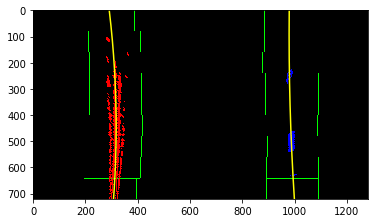

In [10]:
### Create thresholded image with perpective warp 
test_img=mpimg.imread('./test_images/straight_lines1.jpg')
undst=gradmag(hls_chn(cv2.undistort(test_img, mtx, dist, None, mtx),2))
thrshd=aplythrsh(undst,thresh=(50,255))
warped = cv2.warpPerspective(thrshd, M, img_size)

''' Taking from the sliding window approach in the material provided.'''
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
out = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size


The code above must be changed to output the data only for later fitting. 

#### Create Processing Pipeline

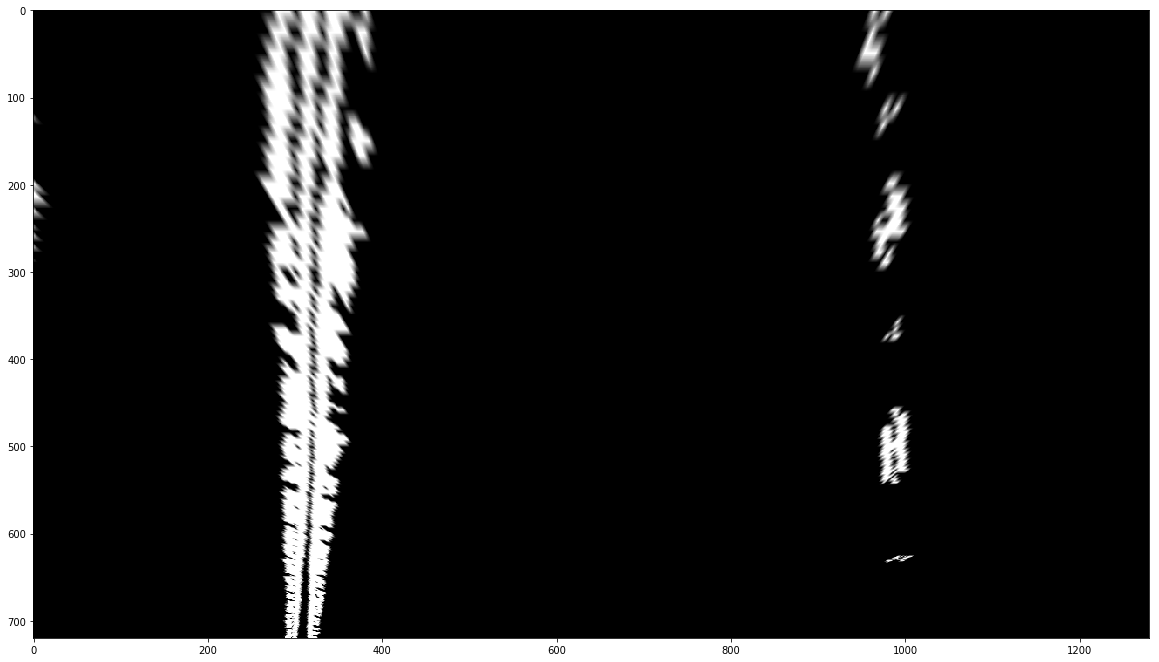

In [11]:
def lanes_func(img,mtx,dist,M):
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    s_gradmag_bin=aplythrsh(gradmag(hls_chn(undst,2)),(25,300))
    s_dir_bin=dir_threshold(hls_chn(undst,2),(0.9,1.2))
    s_grad_bin=np.zeros_like(s_gradmag_bin)
    s_grad_bin[(s_dir_bin==1)&(s_gradmag_bin==1)]=1

    r_thresh_bin=aplythrsh(rgb_chn(undst,0),(130,255))
    r_dir_bin=dir_threshold(rgb_chn(undst,0),(0.7,1.4))
    r_gradmag_bin=aplythrsh(gradmag(rgb_chn(undst,0)),(25,300))
    
    r_grad=np.zeros_like(r_thresh_bin)
    r_grad[(r_dir_bin==1)&(r_gradmag_bin==1)]=1
    
    r_combined=np.zeros_like(r_thresh_bin)
    r_combined[((r_grad==1) & (r_thresh_bin==1))] = 1
    
    l_dir_bin=dir_threshold(lab_chn(undst,0),(0.7,1.4))
    l_gradmag_bin=aplythrsh(gradmag(lab_chn(undst,0)),(25,500))
    l_combined=np.zeros_like(l_dir_bin)
    l_combined[((l_dir_bin==1) & (l_gradmag_bin==1))] = 1
    
    combined=np.zeros_like(r_combined)
    combined[(r_combined==1)&(l_combined==1)|(s_grad_bin==1)]=1
       
    blkimg=np.zeros_like(r_combined)
    #out=255*np.stack((r_grad,r_gradmag_bin,r_dir_bin),2)   
    #out=255*np.stack((r_combined,blkimg,blkimg),2)   
    #out=255*np.stack((r_combined,s_gradmag_bin,l_combined),2)
    
    out=255*np.stack((combined,combined,combined),2)
    out_size = (out.shape[1], out.shape[0])
    warped = cv2.warpPerspective(out, M, out_size)
    return warped
    
## make the variables required globals so the pipeline can access them without other parameters. 

global glb_mtx
glb_mtx = mtx
global glb_dist
glb_dist = dist
global glb_M
glb_M = M

def lanes(img):
    return lanes_func(img,glb_mtx,glb_dist,glb_M)

plt.imshow(lanes(test_img))

### Test Video Creation Pipeline 

In [17]:
from moviepy.editor import VideoFileClip

import os 

if not os.path.exists('test_videos_output'):
    os.mkdir('test_videos_output')

codeTestOut = 'test_videos_output/codeTestOut.mp4'
ct_clip2 = VideoFileClip('./project_video.mp4')
codetest = ct_clip2.subclip(10,15).fl_image(lanes)
%time codetest.write_videofile(codeTestOut, audio=False)



[MoviePy] >>>> Building video test_videos_output/codeTestOut.mp4
[MoviePy] Writing video test_videos_output/codeTestOut.mp4



 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [01:05<00:00,  1.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/codeTestOut.mp4 

Wall time: 1min 6s


In [18]:
# repeating this so I can run this cell by itself. 
codeTestOut = 'test_videos_output/codeTestOut.mp4'
from IPython.core.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/codeTestOut.mp4">
</video>
""".format(codeTestOut))

Check individual colorspace contributions with gradient applied. Tune thresholds and decide on solution. Starting suggestions from lesson. S channel from HLS